In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter 
from scipy.spatial.distance import pdist


In [ ]:
from transformers import AutoTokenizer, DistilBertModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, DistilBertConfig, DistilBertTokenizer, DistilBertTokenizerFast, DistilBertPreTrainedModel, DistilBertForTokenClassification, DistilBertForSequenceClassification

from datasets import Dataset
from accelerate import Accelerator

In [5]:
from bs4 import BeautifulSoup
import re
from sklearn import preprocessing

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 

from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor


import tqdm as notebook_tqdm
from tqdm import tqdm

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings


In [11]:
complaints = pd.read_csv("../data/Xtest_Ypred_df_ComplaintsCSV_exported_DistilBERT_5Iter_LearningRate1e-6.csv")

In [14]:
class TextCleaner():
    def __init__(self):
        pass
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

cleaner = TextCleaner()
complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(cleaner.clean_text)
complaints

,Consumer complaint narrative,Issue
0,a couple years ago i had a dispute with this s...,3
1,on xxxxxxxx i received my credit report and fo...,0
2,on xxxxxxxxxxxx i wrote trans union a letter a...,3
3,i was looking through my credit report today x...,3
4,xxxx xxxx acct xxxx n accordance with the fair...,3
...,...,...
70682,im currently working on identity theft gov and...,0
70683,i am giving you one warning because i will sue...,3
70684,in the beginning of xxxxxxxx i was presented w...,3
70685,i am a recent graduate from xxxx xxxx in xxxx ...,2


y_raw = complaints['Issue']

In [15]:
le = preprocessing.LabelEncoder()
complaints['Issue'] = le.fit_transform(complaints['Issue'].tolist())

In [16]:
y_encoded = complaints['Issue']
y_encoded

0        3
1        0
2        3
3        3
4        3
        ..
70682    0
70683    3
70684    3
70685    2
70686    0
Name: Issue, Length: 70687, dtype: int64

In [ ]:
X = complaints[['Consumer complaint narrative']]
X  


,Consumer complaint narrative
0,a couple years ago i had a dispute with this s...
1,on xxxxxxxx i received my credit report and fo...
2,on xxxxxxxxxxxx i wrote trans union a letter a...
3,i was looking through my credit report today x...
4,xxxx xxxx acct xxxx n accordance with the fair...
...,...
70682,im currently working on identity theft gov and...
70683,i am giving you one warning because i will sue...
70684,in the beginning of xxxxxxxx i was presented w...
70685,i am a recent graduate from xxxx xxxx in xxxx ...


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_encoded)

In [ ]:
ct0 = ColumnTransformer(
        [('tokenizer', TfidfVectorizer(stop_words='english'), 'Consumer complaint narrative')
         ],
        remainder='passthrough')

xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor0', ct0),
        ('xgbc', XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=1000,  #10000, for 92% accuracy (Macro)
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)
        )
    ]
).fit(X_train, y_train) 

/Users/bentonwang/Library/Python/3.13/lib/python/site-packages/xgboost/training.py:183: UserWarning: [13:28:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
y_pred = xgbc_pipe.predict(X_test)

In [21]:
X_test_SHAP = X_test

In [22]:
accuracy_score(y_test, y_pred)

0.8774932805205828

In [23]:
confusion_matrix(y_test, y_pred)

array([[2078,  117,   15,  706,   11],
       [ 175,  622,    5,   43,    5],
       [  15,    9,  427,   39,    4],
       [ 473,   14,   15, 8641,   29],
       [   5,    7,    4,   41,  638]])

In [24]:
print(classification_report(y_test, y_pred, zero_division = 0, target_names=['Attempts to Collect Debt Not Owed', 'Communication Tactics', 'Fraud or Scam', 'Incorrect Information on Your Report', 'Struggling to Pay Mortgage']))  

                                      precision    recall  f1-score   support

   Attempts to Collect Debt Not Owed       0.76      0.71      0.73      2927
               Communication Tactics       0.81      0.73      0.77       850
                       Fraud or Scam       0.92      0.86      0.89       494
Incorrect Information on Your Report       0.91      0.94      0.93      9172
          Struggling to Pay Mortgage       0.93      0.92      0.92       695

                            accuracy                           0.88     14138
                           macro avg       0.86      0.83      0.85     14138
                        weighted avg       0.87      0.88      0.88     14138



# Top Features' Importance Quantification


In [25]:
selection = SelectFromModel(xgbc_pipe[-1], threshold=0.0001, prefit=True)

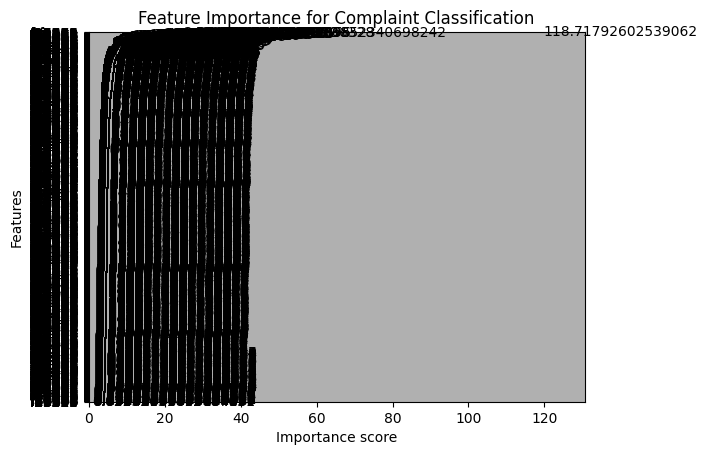

In [26]:
plot_importance_object = plot_importance(xgbc_pipe[-1], importance_type='gain')
plt.title('Feature Importance for Complaint Classification')
plt.show()

In [27]:
X_feature_names = xgbc_pipe[:-1].get_feature_names_out()
X_feature_names

array(['tokenizer__00', 'tokenizer__000', 'tokenizer__0000', ...,
       'tokenizer__zooming', 'tokenizer__zwicker', 'tokenizer__zxxxx'],
      shape=(45001,), dtype=object)

In [28]:
importances = xgbc_pipe[-1].feature_importances_

In [29]:
importance_df = pd.DataFrame({'word': X_feature_names, 'importance': importances})   

In [30]:
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df = importance_df[importance_df['importance'] > 0]

importance_df.head(30)

,word,importance
26732,tokenizer__mute,0.026557
26212,tokenizer__modification,0.012319
12965,tokenizer__declaration,0.008085
17456,tokenizer__feedbacks,0.006441
9275,tokenizer__cfr,0.006181
16772,tokenizer__experian,0.006153
40292,tokenizer__transunion,0.006113
8615,tokenizer__calling,0.005416
16129,tokenizer__equifax,0.005224
34633,tokenizer__revision,0.005161


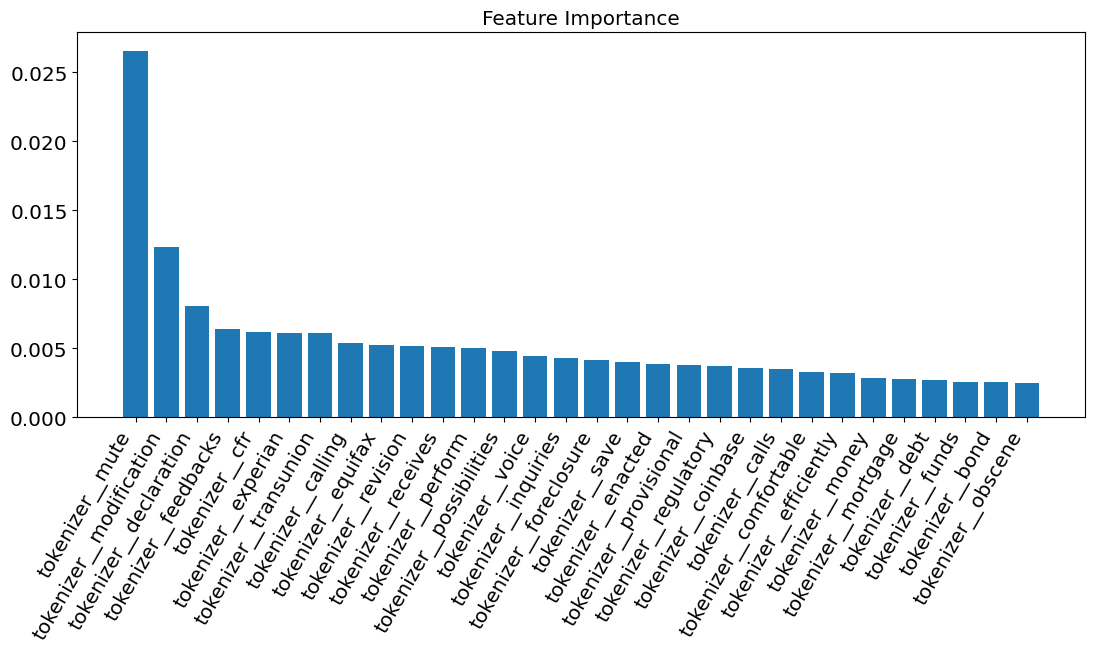

In [31]:
FeatureImportance_BarGraph = pd.DataFrame(zip(xgbc_pipe[:-1].get_feature_names_out(), xgbc_pipe[-1].feature_importances_)).sort_values(1, ascending = False).head(30) #.T
plt.figure(figsize = (13, 5))
plt.bar(FeatureImportance_BarGraph[0], FeatureImportance_BarGraph[1])
plt.xticks(rotation = 60, ha = 'right', size = 'x-large')
plt.yticks(size = 'x-large')
plt.title('Feature Importance', size = 'x-large')
plt.savefig('./visualizations/feature_importance.jpg', bbox_inches = 'tight');

# SHAP

In [32]:
explainer = shap.TreeExplainer(xgbc_pipe[1])
explanation = explainer(xgbc_pipe[0].transform(X_test_SHAP))

In [33]:
explainer.shap_values(xgbc_pipe[0].transform(X_test_SHAP))

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.000197  ,  0.00362985, -0.00028015, -0.00496662,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.00018319,  0.00345579, -0.00058652, -0.01235938,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        , 

In [34]:
explanation[:,:,2]

.values =
array([[ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00058652,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(14138, 45001), dtype=float32)

.base_values =
array([-1.3365952, -1.3365952, -1.3365952, ..., -1.3365952, -1.3365952,
       -1.3365952], shape=(14138,), dtype=float32)

.data =
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 703589 stored elements and shape (14138, 45001)>

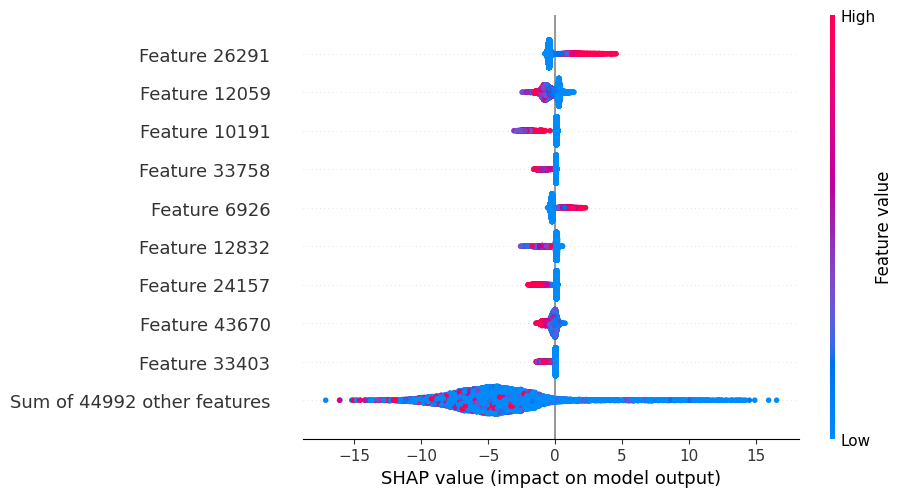

In [35]:
shap.plots.beeswarm(explanation[:,:,2])

In [36]:
xgbc_pipe[:-1].get_feature_names_out()[[26291, 12059, 10191, 33758, 6926, 24157, 43670, 33403]].tolist()  # when n_estimators=1000

['tokenizer__money',
 'tokenizer__credit',
 'tokenizer__collection',
 'tokenizer__reporting',
 'tokenizer__bank',
 'tokenizer__letter',
 'tokenizer__xxxx',
 'tokenizer__remove']

In [37]:
# xgbc_pipe[:-1].get_feature_names_out()[[12059, 26291, 43670, 12832, 6926, 10191, 33758, 33654, 3677]].tolist()  # when n_estimators=10000

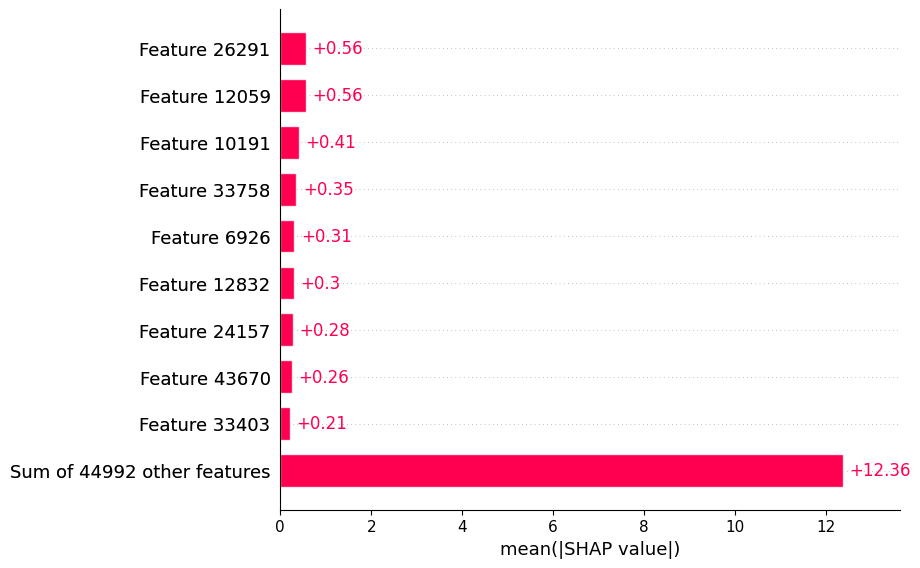

In [38]:
shap.plots.bar(explanation[:,:,2])

In [ ]:
pd.DataFrame({'Consumer complaint narrative': X_test_SHAP['Consumer complaint narrative'], 'SHAP_value':explanation[:,:,2].values[:,0]}).groupby('Consumer complaint narrative')['SHAP_value'].mean().sort_values(ascending = False) 

Consumer complaint narrative
014 xxxx xxxx xxxx letter on unfair or deceptive credit practices the ftc act and the doddfrank act continue to prohibit unfair or deceptive acts or xxxx may determine a statutory violation exists depending on the facts and ftc violations                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             